In [3]:
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 15 14:49:58 2022

@author: Sidi Wu and Cédric Beaulac

Functional autoencoder implementation
"""

# Import modules
import sys
import torch
import torch.nn.init as init
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import save_image
import pandas as pd
import numpy as np
from numpy import *
import seaborn as sns
import matplotlib
#matplotlib.use('TkAgg')
from matplotlib import pyplot as plt
# import skfda as fda
# from skfda import representation as representation
# from skfda.exploratory.visualization import FPCAPlot
# # from skfda.exploratory.visualization import FPCAPlot
# # from skfda.preprocessing.dim_reduction import FPCA
# # from skfda.representation.basis import BSpline, Fourier, Monomial
import scipy
from scipy.interpolate import BSpline
import os
import ignite
import sklearn
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans
import random
from random import seed
from scipy import stats
import statistics
from statistics import stdev
import skfda


In [4]:

# os.chdir('C:/FAE')
os.chdir('C:/Users/Utilisateur/Documents/Master_SSD/STAGE_RECHERCHE/FDA_python')
if not os.getcwd() in sys.path:
    sys.path.append(os.getcwd())
import DataGenerator
from DataGenerator import *
import DataGenerator_NN
from DataGenerator_NN import *
import Functions
from Functions import *


In [12]:
help(DataGenerator)

Help on function DataGenerator in module DataGenerator:

DataGenerator(nc=250, tpts=array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]), classes=4, noise=2)
    # nc: number of data points per *class*, classes: number of classes/cluster, noise:std of the normal noise



In [13]:
##Importation des données sous forme FDA

ElNino_OISST_region_1and2=skfda.datasets.fetch_cran("ElNino_OISST_region_1and2","rainbow")
ElNino_OISST_region_3=skfda.datasets.fetch_cran("ElNino_OISST_region_3","rainbow")
ElNino_OISST_region_4=skfda.datasets.fetch_cran("ElNino_OISST_region_4","rainbow")
ElNino_OISST_region_3and4=skfda.datasets.fetch_cran("ElNino_OISST_region_3and4","rainbow")


c:\Users\Utilisateur\anaconda3\lib\site-packages\rdata\conversion\_conversion.py:843: UserWarning: Missing constructor for R class "sfts". The constructor for class "fts" will be used instead.
  warnings.warn(
c:\Users\Utilisateur\anaconda3\lib\site-packages\rdata\conversion\_conversion.py:843: UserWarning: Missing constructor for R class "fts". The constructor for class "fds" will be used instead.
  warnings.warn(
c:\Users\Utilisateur\anaconda3\lib\site-packages\rdata\conversion\_conversion.py:843: UserWarning: Missing constructor for R class "fds". The underlying R object is returned instead.
  warnings.warn(
c:\Users\Utilisateur\anaconda3\lib\site-packages\rdata\conversion\_conversion.py:843: UserWarning: Missing constructor for R class "sfts". The constructor for class "fts" will be used instead.
  warnings.warn(
c:\Users\Utilisateur\anaconda3\lib\site-packages\rdata\conversion\_conversion.py:843: UserWarning: Missing constructor for R class "fts". The constructor for class "fds" w

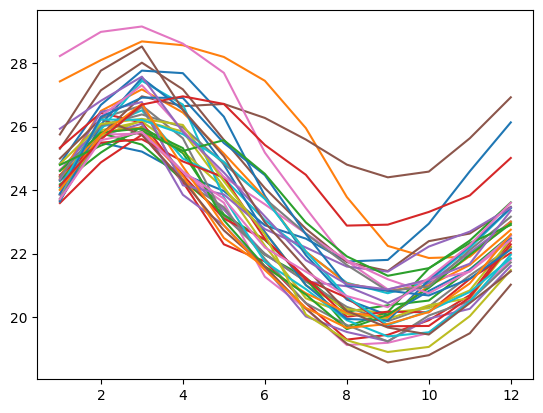

In [14]:
ElNino_OISST_region_1and2_y=ElNino_OISST_region_1and2['ElNino_OISST_region_1and2']['y'].to_numpy()
ElNino_OISST_region_1and2_x=ElNino_OISST_region_1and2['ElNino_OISST_region_1and2']['x']
plt.plot(ElNino_OISST_region_1and2_x,ElNino_OISST_region_1and2_y)
plt.show(
)

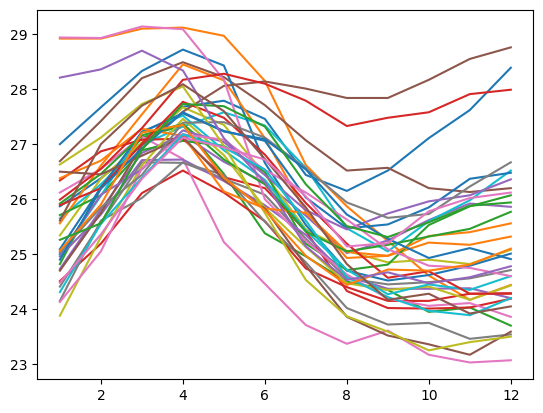

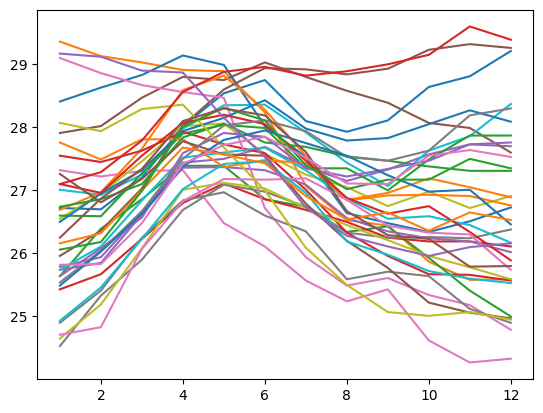

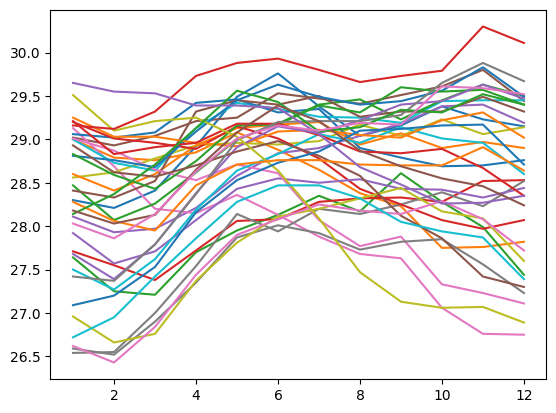

In [15]:
ElNino_OISST_region_3_y=ElNino_OISST_region_3['ElNino_OISST_region_3']['y'].to_numpy()
ElNino_OISST_region_3_x=ElNino_OISST_region_3['ElNino_OISST_region_3']['x']
plt.plot(ElNino_OISST_region_3_x,ElNino_OISST_region_3_y)
plt.show(

)
ElNino_OISST_region_3and4_y=ElNino_OISST_region_3and4['ElNino_OISST_region_3and4']['y'].to_numpy()
ElNino_OISST_region_3and4_x=ElNino_OISST_region_3and4['ElNino_OISST_region_3and4']['x']
plt.plot(ElNino_OISST_region_3and4_x,ElNino_OISST_region_3and4_y)
plt.show(
)


ElNino_OISST_region_4_y=ElNino_OISST_region_4['ElNino_OISST_region_4']['y'].to_numpy()
ElNino_OISST_region_4_x=ElNino_OISST_region_4['ElNino_OISST_region_4']['x']
plt.plot(ElNino_OISST_region_4_x,ElNino_OISST_region_4_y)
plt.show(
)

In [16]:
grid_points=ElNino_OISST_region_1and2_x
[ElNino_OISST_region_1and2_y.shape,

print("grid_points=",grid_points)]

grid_points= [ 1  2  3  4  5  6  7  8  9 10 11 12]


[(12, 37), None]

In [17]:
x0=torch.tensor(ElNino_OISST_region_1and2_y).float().cuda()
x1=torch.tensor(ElNino_OISST_region_3_y).float().cuda()
x2=torch.tensor(ElNino_OISST_region_4_y).float().cuda()
x3=torch.tensor(ElNino_OISST_region_3and4_y).float().cuda()
x0=torch.t(x0)
x1=torch.t(x1)
x2=torch.t(x2)
x3=torch.t(x3)

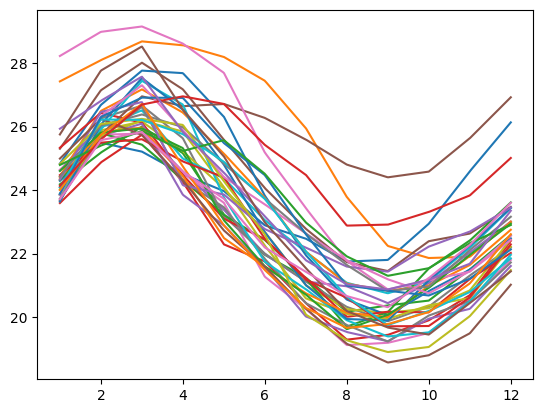

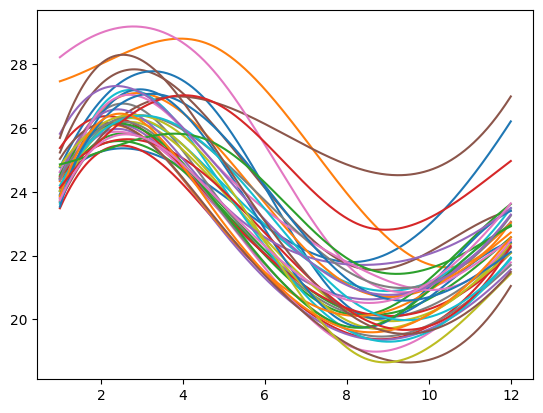

In [18]:
fd=skfda.FDataGrid(torch.t(torch.tensor(ElNino_OISST_region_1and2_y)),grid_points=ElNino_OISST_region_1and2_x)
basis=skfda.representation.basis.BSplineBasis(knots=np.linspace(1,12,4),order=4)
fd_basis=fd.to_basis(basis=basis)
fd.plot()
fd_basis.plot()
plt.show()

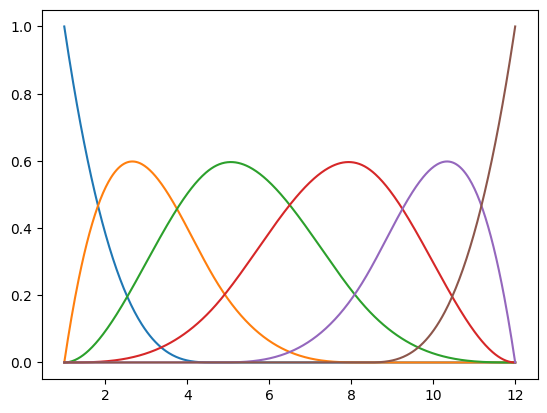

In [19]:
basis.plot()

On choisi le lissage par Bspline dont la base est déterminée par les noeuds linspace(1,12,4) et un order 4 d'interpolation.
Le nombre de basis est donc égale à :
(4+4-2)=6 



In [20]:
class CNN_FAE(nn.Module):
    def __init__(self,):
        super(CNN_FAE,self).__init__()

            
        self.CNN_Conv=nn.Sequential(    
            nn.Conv1d(1,6,kernel_size=5,stride=[1],padding=[1],bias =True,dilation=1),
            
        )    
        self.Linear=nn.Sequential(    
            nn.Linear(10,512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.15,inplace=True),
            nn.Linear(512,256),

            nn.Linear(256,128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.15,inplace=True),
            nn.Linear(128,64),
        )
        self.CNN_ConvTranspose=nn.Sequential(    
            nn.ConvTranspose1d(6,37,stride=1,padding=29,kernel_size=7),
            

        )



    def forward(self,functions):

        conv_out=self.CNN_Conv(functions)
        Linear_out=self.Linear(conv_out)
        deconv_out=self.CNN_ConvTranspose(Linear_out)
        
        
        return deconv_out.float()

In [21]:
x =torch.tensor(ElNino_OISST_region_1and2_y).float().cuda()
w = x.size(1)-1
W = torch.tensor([1/(2*w)]+[1/w]*(w-1)+[1/(2*w)])
W
x.size()
basis


BSplineBasis(domain_range=((1.0, 12.0),), n_basis=6, order=4, knots=(1.0, 4.666666666666666, 8.333333333333332, 12.0))

In [22]:

FD_grid_region_1and_2=skfda.representation.FDataGrid(x0.detach().cpu(),grid_points=ElNino_OISST_region_1and2_x)
FD_grid_region_3=skfda.representation.FDataGrid(x1.detach().cpu(),grid_points=ElNino_OISST_region_3_x)
FD_grid_region_4=skfda.representation.FDataGrid(x2.detach().cpu(),grid_points=ElNino_OISST_region_4_x)
FD_grid_region_3and_4=skfda.representation.FDataGrid(x3.detach().cpu(),grid_points=ElNino_OISST_region_3and4_x)

##Une fois les coefficients récupérés, on en fait une fonction de x puis 
##x vaudra une discrétisation du temps.
##On va zoomer la courbe pour faire de la convolution.


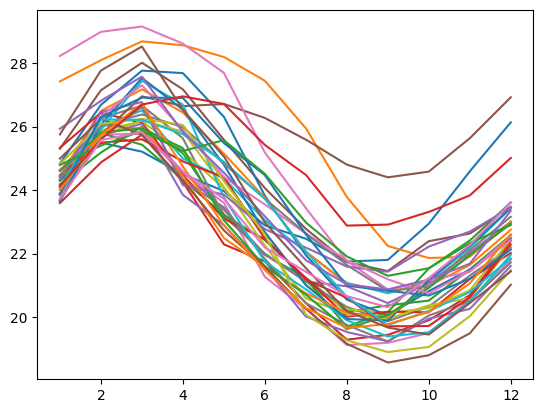

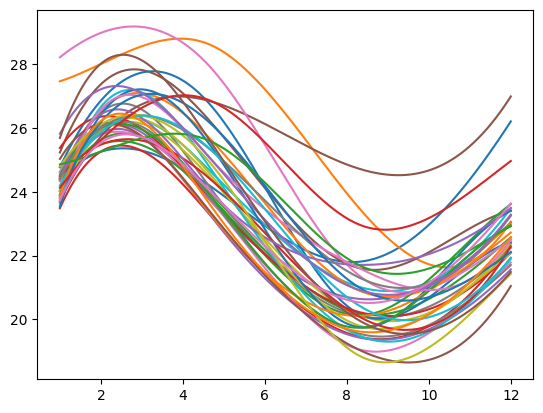

In [23]:

skfda.FDataGrid(x0.detach().cpu(),grid_points=ElNino_OISST_region_1and2_x).plot()
plt.show()
FD_grid_region_1and_2.to_basis(basis).plot()
plt.show()

In [24]:

CNN=CNN_FAE()
CNN=CNN.cuda()
Conv_out=CNN.CNN_Conv(x0[1,:].unsqueeze(0))
[x0.shape,Conv_out.shape,]



[torch.Size([37, 12]), torch.Size([6, 10])]

['conv_out shape=', torch.Size([6, 10])]
Convlayer


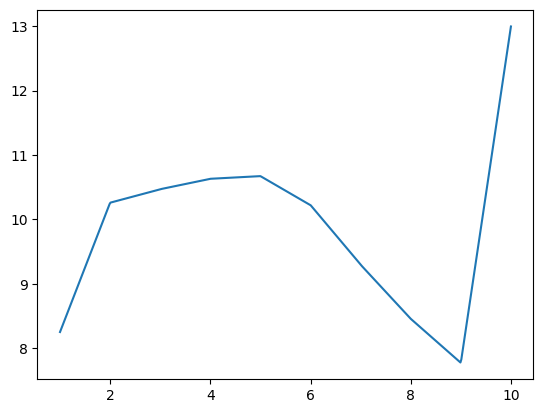

Smoothed convlayer


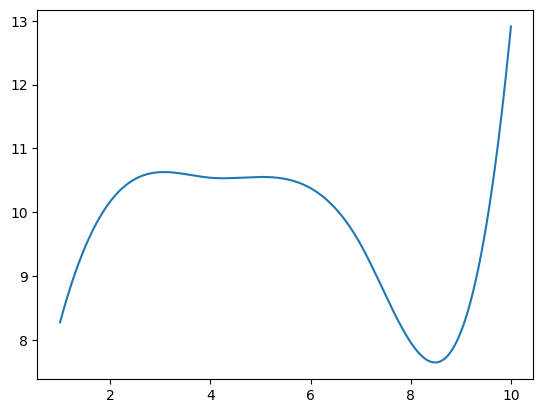

Convlayer


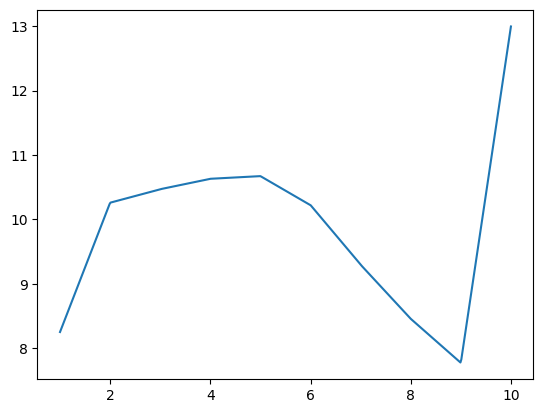

Smoothed convlayer


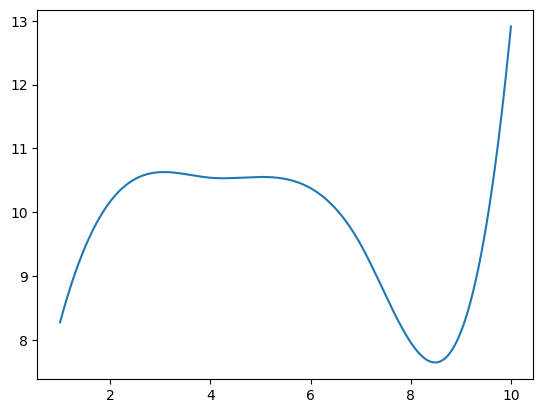

Convlayer


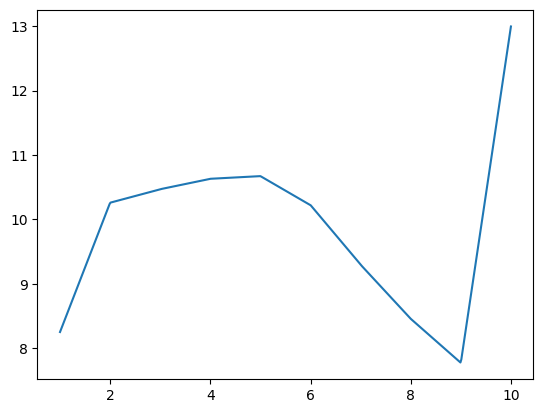

Smoothed convlayer


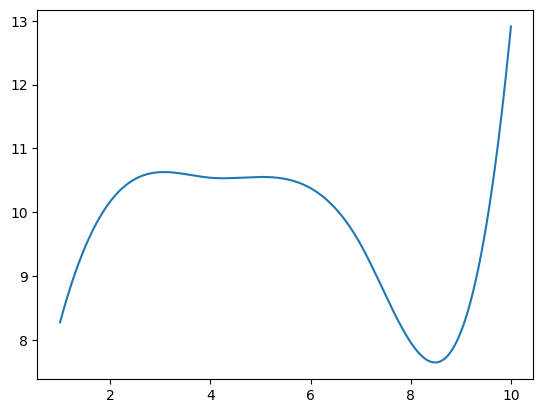

Convlayer


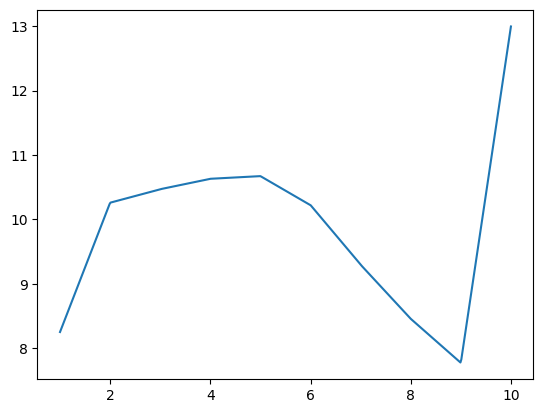

Smoothed convlayer


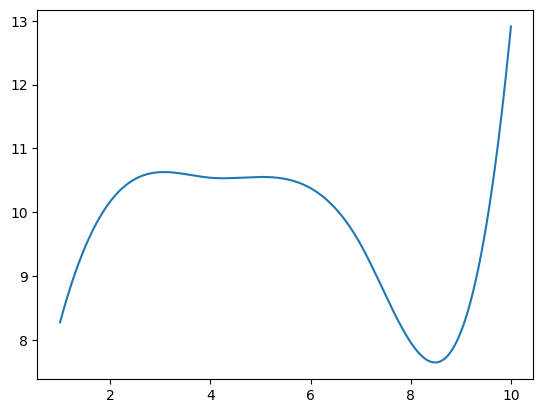

In [36]:

output_CNN_FAE=CNN.CNN_Conv(x0[1,:].unsqueeze(0))
n_conv_out=Conv_out.shape[1]
basis_conv_out=skfda.representation.basis.BSplineBasis(knots=linspace(1,n_conv_out,4))
print(["conv_out shape=",Conv_out.shape])
Conv_out.shape

for i in range(4):
        
        
    CNN.FD=skfda.FDataGrid(Conv_out[1,:].detach().cpu(),grid_points=linspace(1,n_conv_out,n_conv_out))
    print("Convlayer")
    CNN.FD.plot()
    plt.show()
    CNN.FD.to_basis(basis_conv_out).plot()
    print("Smoothed convlayer")
    plt.show()

torch.Size([6, 64])


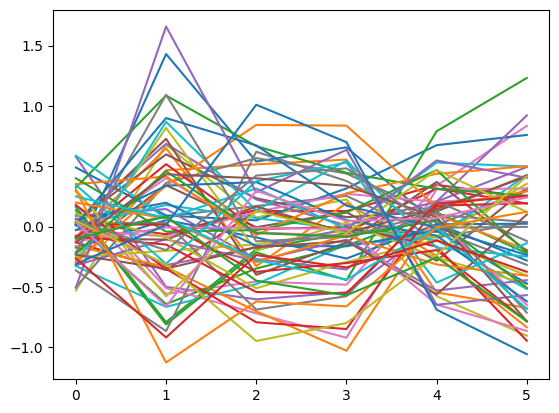

In [37]:

Lin_out=CNN.Linear(Conv_out)
print(Lin_out.shape)
plt.plot(Lin_out.detach().cpu())
plt.show()

In [38]:
n_output_CNN_FAE=CNN(x2[1,:].unsqueeze(0)).shape[1]

[CNN(x0[1,:].unsqueeze(0)).shape,
x0.shape]

[torch.Size([37, 12]), torch.Size([37, 12])]

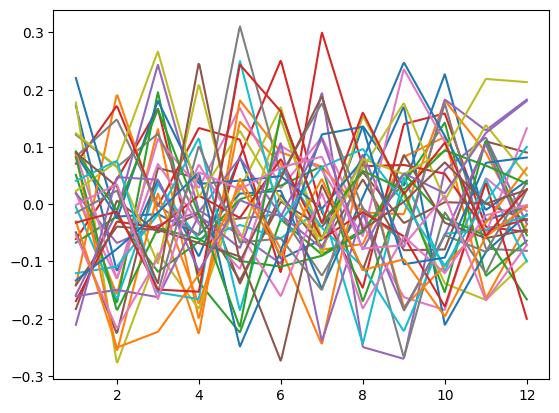

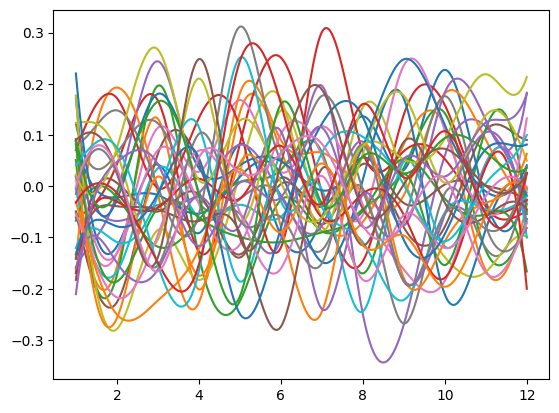

In [39]:

basis_output_CNN_FAE=skfda.representation.basis.BSplineBasis(knots=linspace(1,n_output_CNN_FAE,n_output_CNN_FAE))
FDOutput=skfda.FDataGrid(CNN(x3[0,:].unsqueeze(0))[:,:].detach().cpu(),grid_points=linspace(1,n_output_CNN_FAE,n_output_CNN_FAE))
FDOutput.plot()
plt.show()
FDOutput.to_basis(basis=basis_output_CNN_FAE).plot()
plt.show()

In [41]:
lr=0.001
betas=[0.5,0.999]
batch_size=3

loss_function=nn.MSELoss()
optimizer=optim.Adam(CNN.parameters(),lr=lr,betas=betas)
indice=np.arange(37)


#print("Loader entier=",train_loader.dataset.shape)
#for i,b in enumerate(train_loader):
#    print ("Itération du",i,"ème batch=",b.shape)

In [42]:

from tqdm import tqdm
def train(n_epochs,x0):
    train_loss=torch.tensor(0).cuda()
    train_loader=torch.utils.data.DataLoader(x0)

    for i,functions_train in enumerate(train_loader):
        functions_train=functions_train.float().cuda()
        optimizer.zero_grad()
        output=CNN(functions_train).float().cuda()
        loss=loss_function(output.float(),functions_train.float().cuda())
        
        loss.backward()
        optimizer.step()
        train_loss+=loss.long()
    return train_loss,loss 

        


        


In [47]:
region_de_test=x2
train(3,region_de_test)

(tensor(16, device='cuda:0'),
 tensor(0.3111, device='cuda:0', grad_fn=<MseLossBackward0>))

Ce que l'on recréer


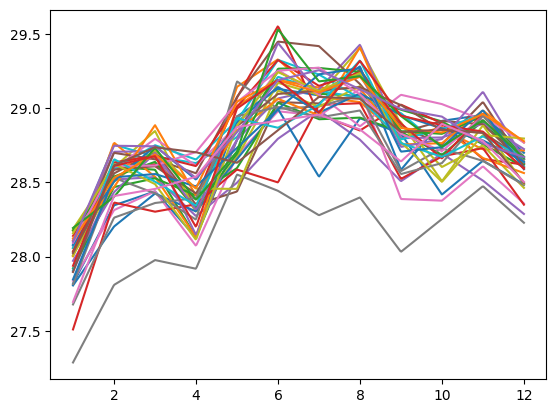

Ce que l'on est censé recréer


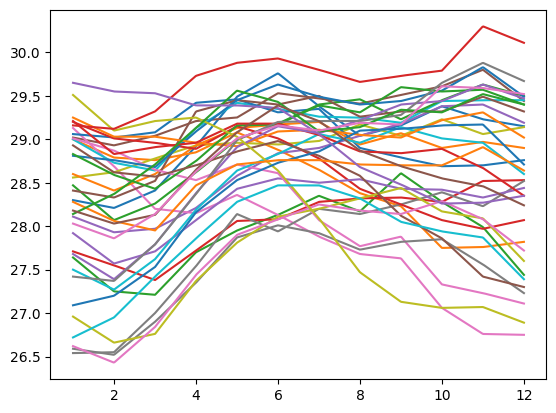

Smooth par B-Spline de ce que l'on a recréé


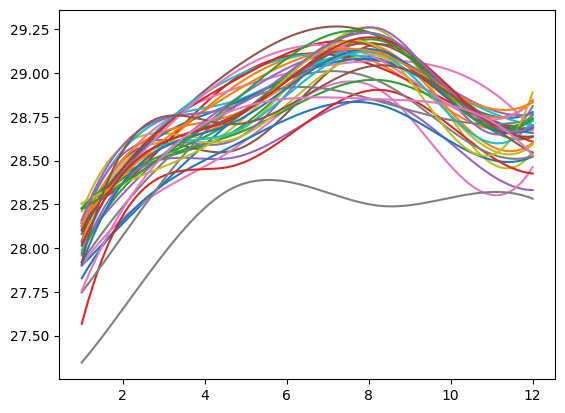

Ce que l'on est censé recréer mais smooth


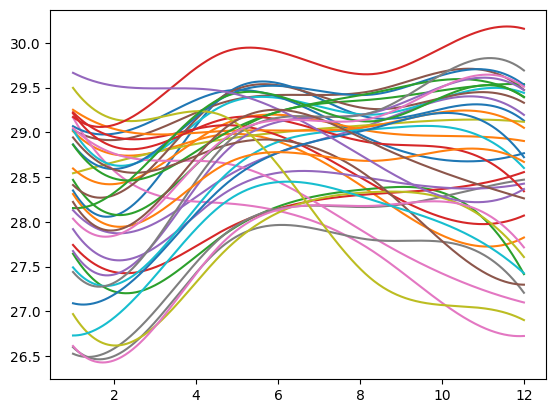

In [48]:

basis_output_CNN_FAE=skfda.representation.basis.BSplineBasis(knots=linspace(1,n_output_CNN_FAE,4))
FDOutput=skfda.FDataGrid(CNN(x1[3,:].unsqueeze(0))[:,:].detach().cpu(),grid_points=linspace(1,n_output_CNN_FAE,n_output_CNN_FAE))
FDOutput.plot()
print("Ce que l'on recréer")
plt.show() 
FD_region_test=skfda.FDataGrid(region_de_test.detach().cpu(),grid_points=ElNino_OISST_region_1and2_x)
FD_region_test.plot()
print("Ce que l'on est censé recréer")
plt.show()
Output_basis=FDOutput.to_basis(basis=basis_output_CNN_FAE)
Output_basis.plot()
print("Smooth par B-Spline de ce que l'on a recréé")
plt.show()
basis_region_de_test=FD_region_test.to_basis(basis_output_CNN_FAE)
basis_region_de_test.plot()
print("Ce que l'on est censé recréer mais smooth")
plt.show()

In [102]:
loss_function(CNN(x2[1,:].unsqueeze(0)),x1)

tensor(9.9614, device='cuda:0', grad_fn=<MseLossBackward0>)

In [49]:
import gc
import torch
torch.cuda.empty_cache()
gc.collect()

18348